In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('C:\\Users\\khush\\Documents\\amazon_sales_FULL_ANALYSIS.csv')

print("Step 1: Defining adapted RFM metrics (Review Recency, Review Frequency, Monetary Engagement)...")

# --- TASK 1 & 2: Define Metrics & Choose Reference Date ---
# Since we lack real dates, we create a proxy 'last_review_date' for demonstration.
# We'll assume reviews happened in the last 365 days, with higher ratings being more recent.
np.random.seed(42)  # For reproducible 'fake' dates
most_recent_date = datetime(2024, 5, 1)
df['last_review_date'] = most_recent_date - pd.to_timedelta(
    np.random.randint(0, 365, size=len(df)) * (1 / (df['rating']+0.1)),  # Higher rating = more recent bias
    unit='D'
)
reference_date = df['last_review_date'].max()
print(f"   Reference Date for Recency set to: {reference_date.date()}")

# --- TASK 3: Group Data by User ID (user_id) to Calculate RFM ---
rfm_data = df.groupby('user_id').agg({
    'last_review_date': lambda x: (reference_date - x.max()).days,  # Recency: Days since last review
    'product_id': 'nunique',                                        # Frequency: Unique products reviewed
    'estimated_revenue': 'sum'                                      # Monetary: Sum of reviewed products' value
}).reset_index()

rfm_data.columns = ['customer_id', 'recency', 'frequency', 'monetary']
print("   RFM raw values calculated for each user.")

# --- TASK 4: Assign RFM Rankings (1-5, where 5 is best) ---
# Use .qcut to create quintiles (5 groups). For Recency, lower days is better, so we invert.
rfm_data['R_rank'] = pd.qcut(rfm_data['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm_data['F_rank'] = pd.qcut(rfm_data['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_data['M_rank'] = pd.qcut(rfm_data['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Convert ranks to numeric
rfm_data['R_rank'] = pd.to_numeric(rfm_data['R_rank'])
rfm_data['F_rank'] = pd.to_numeric(rfm_data['F_rank'])
rfm_data['M_rank'] = pd.to_numeric(rfm_data['M_rank'])

print("   RFM scores (1-5) assigned.")
print(rfm_data.head())

Step 1: Defining adapted RFM metrics (Review Recency, Review Frequency, Monetary Engagement)...
   Reference Date for Recency set to: 2024-05-01
   RFM raw values calculated for each user.
   RFM scores (1-5) assigned.
                                         customer_id  recency  frequency  \
0  AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,AHWEYO2IJ5I5GDWZA...       24          1   
1  AE23RS3W7GZO7LHYKJU6KSKVM4MQ,AEQUNEY6GQOTEGUMS...       14          1   
2                       AE242TR3GQ6TYC6W4SJ5UYYKBTYQ       55          1   
3  AE27UOZENYSWCQVQRRUQIV2ZM7VA,AGMYSLV6NNOAYES25...       23          4   
4  AE2JTMRKTUOIVIZWS2WDGTMNTU4Q,AF4QXCB32VC2DVE7O...       18          2   

      monetary  R_rank  F_rank  M_rank  
0     630960.0       4       1       2  
1   82656651.0       5       1       5  
2       4788.0       2       1       1  
3  673119506.0       4       5       5  
4    6044198.0       4       5       3  


In [8]:
# --- TASK 6 & 7: Define Segments & Assign Customers ---
print("\nStep 2: Defining and assigning customer segments...")

# Create a combined RFM score string (e.g., '5-5-5')
rfm_data['RFM_Score'] = rfm_data['R_rank'].astype(str) + '-' + rfm_data['F_rank'].astype(str) + '-' + rfm_data['M_rank'].astype(str)

# Define segmentation rules based on scores
def assign_segment(row):
    if row['R_rank'] >= 4 and row['F_rank'] >= 4 and row['M_rank'] >= 4:
        return 'High-Value'
    elif row['R_rank'] >= 4 and row['F_rank'] <= 2 and row['M_rank'] <= 2:
        return 'New'
    elif row['R_rank'] <= 2 and row['F_rank'] >= 3 and row['M_rank'] >= 3:
        return 'At-Risk'
    elif row['R_rank'] <= 2 and row['F_rank'] <= 2 and row['M_rank'] <= 2:
        return 'Lost'
    else:
        return 'Regular'

rfm_data['segment'] = rfm_data.apply(assign_segment, axis=1)

# --- TASK 8: Analyze Purchase Behavior in Each Segment ---
segment_analysis = rfm_data.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
segment_analysis.columns = ['num_customers', 'avg_recency_days', 'avg_frequency', 'avg_monetary']
print("   Customer segments created and analyzed:")
print(segment_analysis)


Step 2: Defining and assigning customer segments...
   Customer segments created and analyzed:
            num_customers  avg_recency_days  avg_frequency  avg_monetary
segment                                                                 
At-Risk               156             67.66           1.10  4.535178e+07
High-Value            119             14.21           1.97  3.482757e+08
Lost                   90             70.83           1.00  4.862144e+05
New                    69             15.59           1.00  5.333958e+05
Regular               760             38.58           1.05  3.068359e+07



Step 3: Creating visualizations...


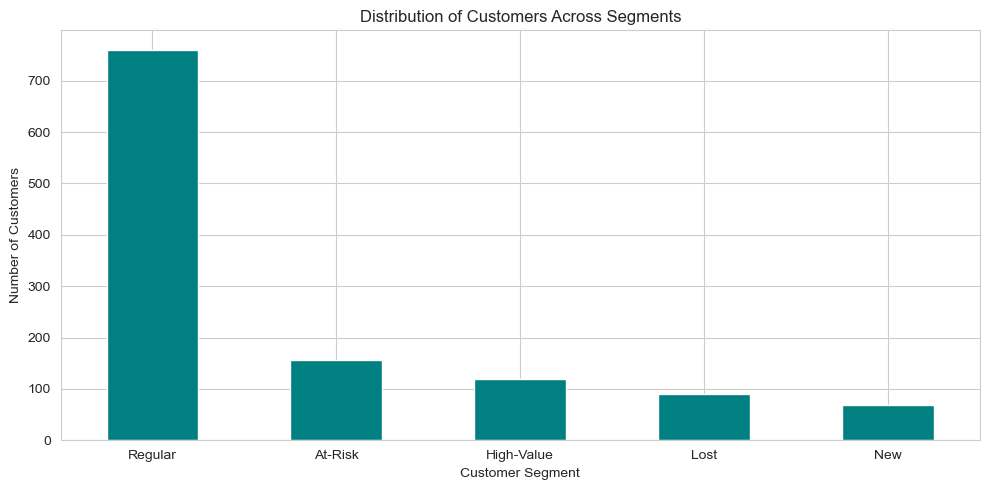

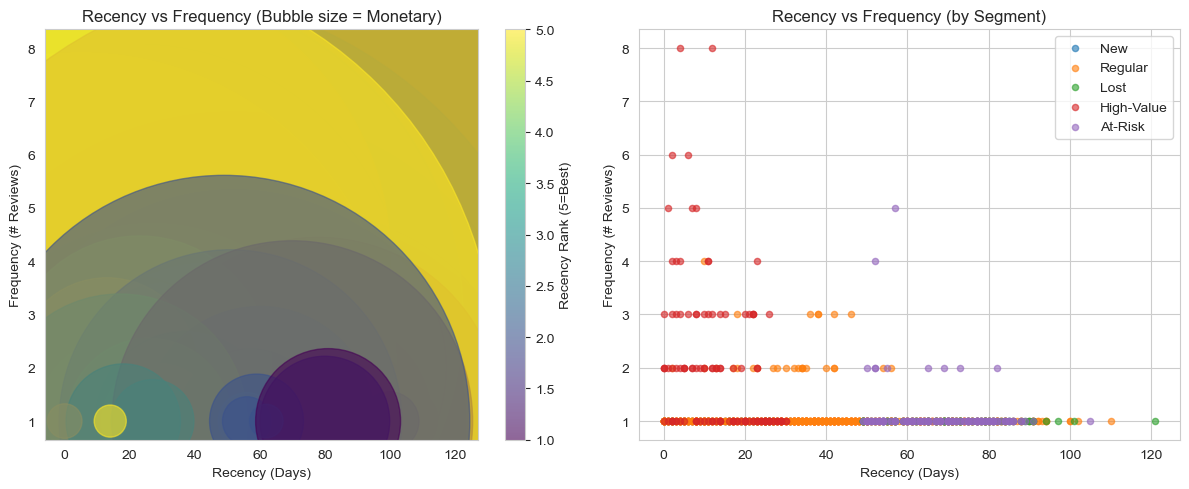

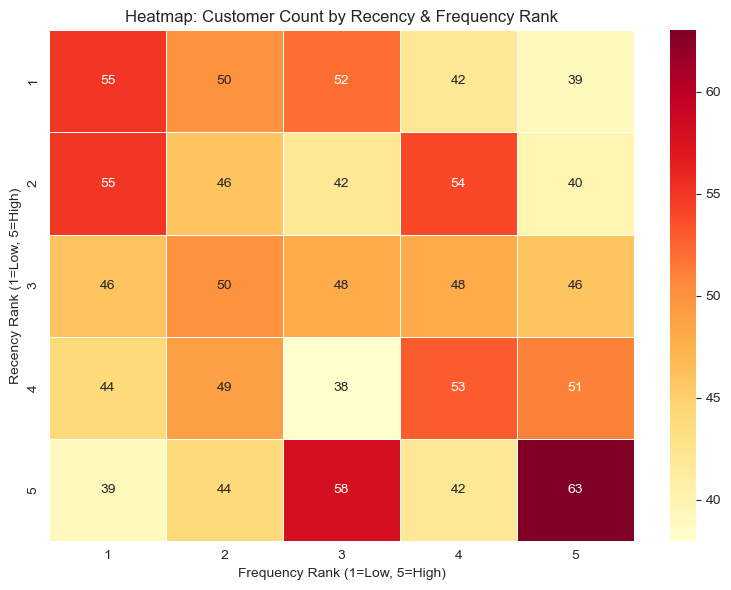

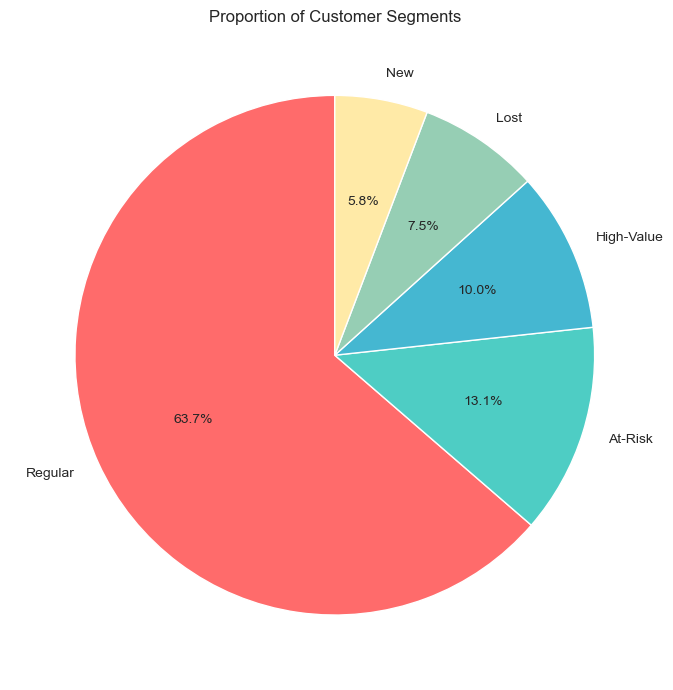

   Visualizations saved as PNG files.


In [9]:
print("\nStep 3: Creating visualizations...")
sns.set_style("whitegrid")

# --- TASK 12: Bar Chart for Segment Distribution ---
plt.figure(figsize=(10, 5))
segment_counts = rfm_data['segment'].value_counts()
segment_counts.plot(kind='bar', color='teal')
plt.title('Distribution of Customers Across Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('segment_distribution_bar.png', dpi=300)  # Save the chart
plt.show()

# --- TASK 13: Scatter Plot for R vs F vs M ---
fig = plt.figure(figsize=(12, 5))
# Plot 1: Recency vs Frequency, colored by Segment
ax1 = fig.add_subplot(121)
scatter = ax1.scatter(rfm_data['recency'], rfm_data['frequency'], c=rfm_data['R_rank'], cmap='viridis', alpha=0.6, s=rfm_data['monetary']/1000)
ax1.set_xlabel('Recency (Days)')
ax1.set_ylabel('Frequency (# Reviews)')
ax1.set_title('Recency vs Frequency (Bubble size = Monetary)')
plt.colorbar(scatter, ax=ax1, label='Recency Rank (5=Best)')

# Plot 2: Segment-wise view
ax2 = fig.add_subplot(122)
for seg in rfm_data['segment'].unique():
    seg_data = rfm_data[rfm_data['segment'] == seg]
    ax2.scatter(seg_data['recency'], seg_data['frequency'], label=seg, alpha=0.6, s=20)
ax2.set_xlabel('Recency (Days)')
ax2.set_ylabel('Frequency (# Reviews)')
ax2.set_title('Recency vs Frequency (by Segment)')
ax2.legend()
plt.tight_layout()
plt.savefig('rfm_scatter_plots.png', dpi=300)
plt.show()

# --- TASK 14: Heatmap for RFM Score Density ---
# Create a pivot table for heatmap: average Monetary value per R and F rank
heatmap_data = rfm_data.pivot_table(index='R_rank', columns='F_rank', values='monetary', aggfunc='count', fill_value=0)
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', linewidths=.5)
plt.title('Heatmap: Customer Count by Recency & Frequency Rank')
plt.xlabel('Frequency Rank (1=Low, 5=High)')
plt.ylabel('Recency Rank (1=Low, 5=High)')
plt.tight_layout()
plt.savefig('rfm_heatmap.png', dpi=300)
plt.show()

# --- TASK 15: Pie Chart for Segment Proportions ---
plt.figure(figsize=(7, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proportion of Customer Segments')
plt.tight_layout()
plt.savefig('segment_pie_chart.png', dpi=300)
plt.show()

print("   Visualizations saved as PNG files.")

In [10]:
# --- TASK 18: Save the Updated Dataset ---
# Merge the RFM segments back to your main dataframe (optional)
df_with_rfm = df.merge(rfm_data[['customer_id', 'segment', 'RFM_Score']], 
                       left_on='user_id', right_on='customer_id', how='left')
# Save it
final_file_path = 'C:\\Users\\khush\\Documents\\amazon_sales_with_RFM.csv'
df_with_rfm.to_csv(final_file_path, index=False)
print(f"\nStep 4: Final dataset with RFM segments saved to:\n{final_file_path}")


Step 4: Final dataset with RFM segments saved to:
C:\Users\khush\Documents\amazon_sales_with_RFM.csv
